In [ ]:
# Notebook 5 — ResNet50 Fine-Tuned (7-Class Skin Lesion Classification)
# Colab-ready

# 0) Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled GPU memory growth.")
    except:
        pass




TensorFlow: 2.19.0
GPU available: []


In [ ]:
# 1) Paths & Config
IMAGE_FOLDER = "/content/drive/MyDrive/HAM10000_images"   # where images live (Notebook1 should have created/cleaned this)
SPLITS_DIR = "/content/drive/MyDrive/splits"              # output from Notebook 1: df_train.csv, df_val.csv, df_test.csv
OUTPUT_DIR = "/content/drive/MyDrive/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 7




In [ ]:
# 2) Load CSV splits
df_train = pd.read_csv(f"{SPLITS_DIR}/df_train.csv")
df_val   = pd.read_csv(f"{SPLITS_DIR}/df_val.csv")
df_test  = pd.read_csv(f"{SPLITS_DIR}/df_test.csv")

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))

# Ensure filepath exists
for d in [df_train, df_val, df_test]:
    if 'filepath' not in d.columns:
        d['filename'] = d['image_id'].astype(str) + ".jpg"
        d['filepath'] = d['filename'].apply(lambda x: os.path.join(IMAGE_FOLDER, x))




Train: 29491 Val: 861 Test: 1780


In [ ]:
# 3) Generators — MUST use ResNet preprocess
train_gen = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_gen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
test_gen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

train_flow = train_gen.flow_from_dataframe(
    df_train, x_col="filepath", y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=True
)

val_flow = val_gen.flow_from_dataframe(
    df_val, x_col="filepath", y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

test_flow = test_gen.flow_from_dataframe(
    df_test, x_col="filepath", y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)

print("Classes:", train_flow.class_indices)




Found 29491 validated image filenames belonging to 7 classes.
Found 861 validated image filenames belonging to 7 classes.
Found 1780 validated image filenames belonging to 7 classes.
Classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# 4) Build Model (ResNet50)
base_res = ResNet50(weights='imagenet', include_top=False,
                    input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all except last 50 layers → prevents overfitting
for layer in base_res.layers[:-50]:
    layer.trainable = False
for layer in base_res.layers[-50:]:
    layer.trainable = True

x = base_res.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

resnet_model = Model(inputs=base_res.input, outputs=preds)

resnet_model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()




94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 17,476,871 (66.67 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [ ]:
# 5) Callbacks
save_path = f"{OUTPUT_DIR}/resnet50_best.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True, verbose=1)
]




In [ ]:
# 6) Train
history = resnet_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS,
    callbacks=callbacks
)


resnet_model.save(f"{OUTPUT_DIR}/resnet50_last.h5")
print("Model saved!")




/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7260 - loss: 0.7566
Epoch 1: val_loss improved from inf to 0.89989, saving model to /content/drive/MyDrive/models/resnet50_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 7763s 8s/step - accuracy: 0.7261 - loss: 0.7562 - val_accuracy: 0.7491 - val_loss: 0.8999 - learning_rate: 1.0000e-04
Epoch 2/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9391 - loss: 0.1757
Epoch 2: val_loss did not improve from 0.89989
922/922 ━━━━━━━━━━━━━━━━━━━━ 650s 705ms/step - accuracy: 0.9391 - loss: 0.1756 - val_accuracy: 0.7526 - val_loss: 1.0005 - learning_rate: 1.0000e-04
Epoch 3/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9621 - loss: 0.1167
Epoch 3: val_loss did not improve from 0.89989
922/922 ━━━━━━━━━━━━━━━━━━━━ 656s 711ms/step - accuracy: 0.9621 - loss: 0.1167 - val_accuracy: 0.7433 - val_loss: 0.9982 - learning_rate: 1.0000e-04
Epoch 4/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.9737 - loss: 0.0769
Epoch 4: val_loss improved from 0.89989 to 0.86974, saving model to /content/drive/MyDrive/models/resnet50_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 725s 759ms/step - accuracy: 0.9737 - loss: 0.0769 - val_accuracy: 0.8014 - val_loss: 0.8697 - learning_rate: 1.0000e-04
Epoch 5/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9779 - loss: 0.0700
Epoch 5: val_loss did not improve from 0.86974
922/922 ━━━━━━━━━━━━━━━━━━━━ 668s 724ms/step - accuracy: 0.9779 - loss: 0.0700 - val_accuracy: 0.7700 - val_loss: 1.0104 - learning_rate: 1.0000e-04
Epoch 6/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.9813 - loss: 0.0592
Epoch 6: val_loss did not improve from 0.86974
922/922 ━━━━━━━━━━━━━━━━━━━━ 684s 742ms/step - accuracy: 0.9813 - loss: 0.0592 - val_accuracy: 0.7654 - val_loss: 1.1416 - learning_rate: 1.0000e-04
Epoch 7/10
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.9838 - loss: 0.0537
Epoch 7: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 7: val_loss did not improve from 0.86974
922/922 ━━━━━━━━━━━━━━━━━━━━ 673s 729ms/step - accuracy: 0.9838 - loss

Model saved!


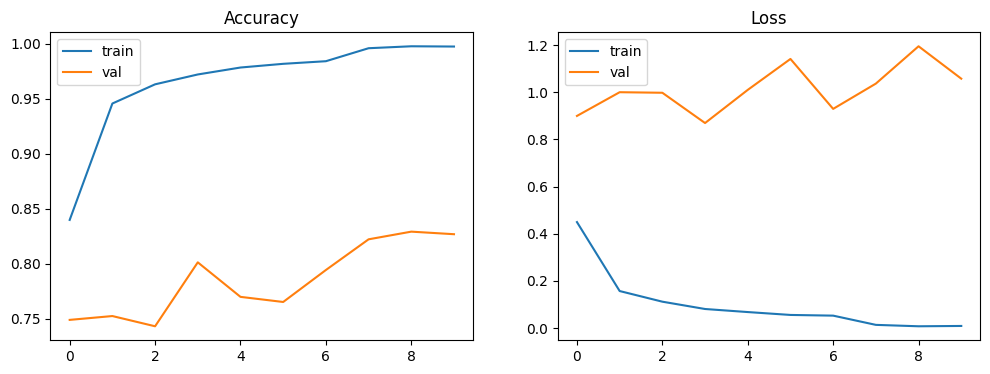

In [ ]:
# 7) Plot curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
plt.title('Accuracy'); plt.legend(['train','val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
plt.title('Loss'); plt.legend(['train','val'])
plt.show()




56/56 ━━━━━━━━━━━━━━━━━━━━ 1931s 35s/step - accuracy: 0.7672 - loss: 1.0418

Test Accuracy: 77.53%
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 409ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.30      0.41        54
         bcc       0.73      0.46      0.57        89
         bkl       0.49      0.82      0.61       205
          df       0.64      0.33      0.44        21
         mel       0.52      0.55      0.53       220
          nv       0.93      0.87      0.89      1171
        vasc       0.93      0.65      0.76        20

    accuracy                           0.78      1780
   macro avg       0.70      0.57      0.60      1780
weighted avg       0.80      0.78      0.78      1780



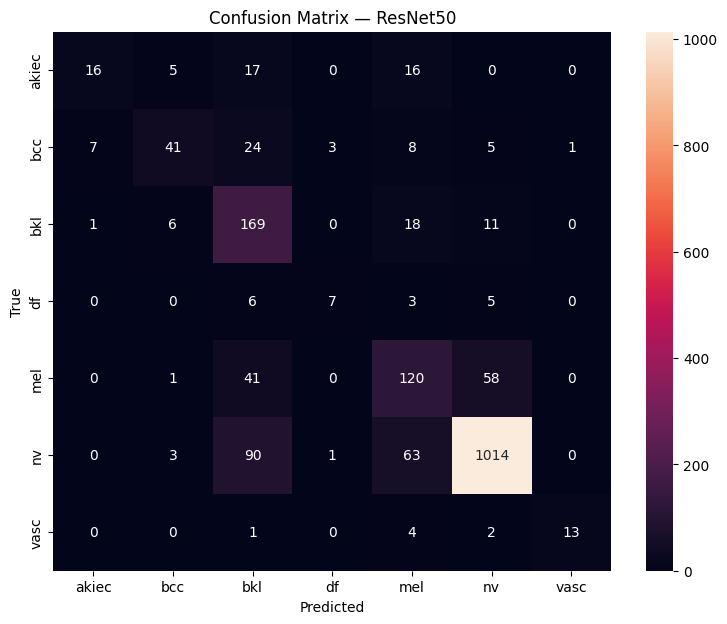

In [ ]:
# 8) Evaluation — Load Best Model
best = load_model(save_path)

loss, acc = best.evaluate(test_flow, verbose=1)
print(f"\nTest Accuracy: {acc*100:.2f}%")

# Predictions
test_flow.reset()
y_prob = best.predict(test_flow, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_flow.classes

# Mapping
inv_class_map = {v:k for k,v in train_flow.class_indices.items()}

y_pred_lab = [inv_class_map[i] for i in y_pred]
y_true_lab = [inv_class_map[i] for i in y_true]

print("\nClassification Report:")
print(classification_report(y_true_lab, y_pred_lab))

# Confusion Matrix
cm = confusion_matrix(y_true_lab, y_pred_lab, labels=list(inv_class_map.values()))

plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=inv_class_map.values(),
            yticklabels=inv_class_map.values())
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [ ]:

# 9) Inference — Upload image and predict
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_resnet(model, img_path):
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = resnet_preprocess(arr)
    prob = model.predict(arr)[0]
    idx = np.argmax(prob)
    return inv_class_map[idx], prob[idx]

print("Upload images to classify:")
uploaded = files.upload()
for fn in uploaded.keys():
    label, confidence = predict_resnet(best, fn)
    print(f"{fn} → {label} ({confidence*100:.2f}%)")


Upload images to classify:
